In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:

# Challenge 1

# read in the data:
import pandas as pd
df_1 = pd.read_csv('data files/turnstile_190706.txt')
df_2 = pd.read_csv('data files/turnstile_190713.txt')
df_3 = pd.read_csv('data files/turnstile_190720.txt')
df_4 = pd.read_csv('data files/turnstile_190727.txt')
df_5 = pd.read_csv('data files/turnstile_190803.txt')
df_6 = pd.read_csv('data files/turnstile_190810.txt')
df_7 = pd.read_csv('data files/turnstile_190817.txt')
df_8 = pd.read_csv('data files/turnstile_190824.txt')
df_9 = pd.read_csv('data files/turnstile_190831.txt')

#concatenate
df_combined = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9])

In [3]:
# Column name 'EXITS' needs to be formatted to remove extra spaces
print(df_combined.columns)
df_combined.rename(columns={df_combined.columns[10]:'EXITS'}, inplace=True)
print(df_combined.columns)

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')
Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')


In [4]:
# Challenge 2

# What data type did pandas assign values in columns 'Date' and 'Time'?
print(type(df_combined.DATE.iloc[0]), type(df_combined.TIME.iloc[0]))

# Combine 'Date' and 'Time' columns and format into a datetime object
df_combined['DATETIME'] = pd.to_datetime(df_combined['DATE']+ ' ' + df_combined['TIME'])
#df_combined.drop(columns=['DATE','TIME'], inplace=True, axis=1)
print(df_combined.head())

<class 'str'> <class 'str'>
    C/A  UNIT       SCP STATION LINENAME DIVISION        DATE      TIME  \
0  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/29/2019  00:00:00   
1  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/29/2019  08:00:00   
2  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/29/2019  12:00:00   
3  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/29/2019  16:00:00   
4  A002  R051  02-00-00   59 ST  NQR456W      BMT  06/29/2019  20:00:00   

      DESC  ENTRIES    EXITS            DATETIME  
0  REGULAR  7116734  2410183 2019-06-29 00:00:00  
1  REGULAR  7116770  2410218 2019-06-29 08:00:00  
2  REGULAR  7116856  2410288 2019-06-29 12:00:00  
3  REGULAR  7117076  2410346 2019-06-29 16:00:00  
4  REGULAR  7117340  2410387 2019-06-29 20:00:00  


In [5]:
# group by turnstile and date, take the first value for each day
turnstiles_daily = (df_combined
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .first())

In [6]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-6-a52010f25ff0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_daily


In [7]:
# remove NaN
turnstiles_daily.dropna(subset=['PREV_DATE'],axis=0,inplace=True)

In [8]:
# check which stations have turnstiles with fewer ENTRIES than the previous day
(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-06-00  59 ST               1
A007  R079  01-05-01  5 AV/59 ST          1
A011  R080  01-03-00  57 ST-7 AV         10
A025  R023  01-03-01  34 ST-HERALD SQ    62
A035  R170  00-00-01  14 ST-UNION SQ      1
                                         ..
R622  R123  00-00-00  FRANKLIN AV        62
R629  R065  00-00-01  ROCKAWAY AV         1
R645  R110  00-03-02  FLATBUSH AV-B.C     2
R646  R110  01-00-01  FLATBUSH AV-B.C    62
R730  R431  00-00-04  EASTCHSTER/DYRE    58
Length: 193, dtype: int64

In [9]:
# check which stations have turnstiles with fewer EXITS than the previous day
(turnstiles_daily[turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-06-00  59 ST               1
A007  R079  01-05-01  5 AV/59 ST          1
A011  R080  01-03-00  57 ST-7 AV         13
A035  R170  00-00-01  14 ST-UNION SQ      1
A043  R462  00-03-03  CANAL ST            1
                                         ..
R621  R060  00-03-01  EASTN PKWY-MUSM     1
R622  R123  00-00-00  FRANKLIN AV        62
R629  R065  00-00-01  ROCKAWAY AV         1
R645  R110  00-03-02  FLATBUSH AV-B.C     2
R646  R110  01-00-01  FLATBUSH AV-B.C    62
Length: 186, dtype: int64

In [10]:
# If the counter is reversed, make negative values positive
# If difference between days is >= 1 million, set daily ENTRIES to min value between ENTRIES and prev_ENTRIES
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = 0
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [11]:
# If the counter is reversed, make negative values positive
# If difference between days is >= 1 million, set daily EXITS to min value between EXITS and prev_EXITS
def get_daily_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = 0
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [12]:
#clean entries
mask_entries = (turnstiles_daily["DAILY_ENTRIES"] != 0)
turnstiles_daily_entries_clean = turnstiles_daily[mask_entries]

In [13]:
turnstiles_daily_entries_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270016 entries, 1 to 307527
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   C/A            270016 non-null  object        
 1   UNIT           270016 non-null  object        
 2   SCP            270016 non-null  object        
 3   STATION        270016 non-null  object        
 4   DATE           270016 non-null  object        
 5   LINENAME       270016 non-null  object        
 6   DIVISION       270016 non-null  object        
 7   TIME           270016 non-null  object        
 8   DESC           270016 non-null  object        
 9   ENTRIES        270016 non-null  int64         
 10  EXITS          270016 non-null  int64         
 11  DATETIME       270016 non-null  datetime64[ns]
 12  PREV_DATE      270016 non-null  object        
 13  PREV_ENTRIES   270016 non-null  float64       
 14  PREV_EXITS     270016 non-null  float64       
 15  

In [14]:
#clean exits from the cleaned entries df
mask_exits = (turnstiles_daily_entries_clean["DAILY_EXITS"] != 0)
turnstiles_daily_exits_clean = turnstiles_daily_entries_clean[mask_exits]

In [15]:
turnstiles_daily_exits_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262536 entries, 1 to 307464
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   C/A            262536 non-null  object        
 1   UNIT           262536 non-null  object        
 2   SCP            262536 non-null  object        
 3   STATION        262536 non-null  object        
 4   DATE           262536 non-null  object        
 5   LINENAME       262536 non-null  object        
 6   DIVISION       262536 non-null  object        
 7   TIME           262536 non-null  object        
 8   DESC           262536 non-null  object        
 9   ENTRIES        262536 non-null  int64         
 10  EXITS          262536 non-null  int64         
 11  DATETIME       262536 non-null  datetime64[ns]
 12  PREV_DATE      262536 non-null  object        
 13  PREV_ENTRIES   262536 non-null  float64       
 14  PREV_EXITS     262536 non-null  float64       
 15  

In [16]:
#rename final cleaned entries and exits df for easier reference
turnstiles_daily_cleaned = turnstiles_daily_exits_clean

In [17]:
turnstiles_daily_cleaned['DAILY_TOTALS'] = turnstiles_daily_cleaned.apply(lambda row: row.DAILY_ENTRIES + row.DAILY_EXITS, axis=1)

<ipython-input-17-0b594facd523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turnstiles_daily_cleaned['DAILY_TOTALS'] = turnstiles_daily_cleaned.apply(lambda row: row.DAILY_ENTRIES + row.DAILY_EXITS, axis=1)


In [18]:
turnstiles_daily_cleaned.head()

,C/A,UNIT,SCP,STATION,DATE,LINENAME,DIVISION,TIME,DESC,ENTRIES,EXITS,DATETIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
1,A002,R051,02-00-00,59 ST,06/30/2019,NQR456W,BMT,00:00:00,REGULAR,7117480,2410406,2019-06-30,06/29/2019,7116734.0,2410183.0,746.0,223.0,969.0
2,A002,R051,02-00-00,59 ST,07/01/2019,NQR456W,BMT,00:00:00,REGULAR,7118119,2410590,2019-07-01,06/30/2019,7117480.0,2410406.0,639.0,184.0,823.0
3,A002,R051,02-00-00,59 ST,07/02/2019,NQR456W,BMT,00:00:00,REGULAR,7119610,2410993,2019-07-02,07/01/2019,7118119.0,2410590.0,1491.0,403.0,1894.0
4,A002,R051,02-00-00,59 ST,07/03/2019,NQR456W,BMT,00:00:00,REGULAR,7121181,2411468,2019-07-03,07/02/2019,7119610.0,2410993.0,1571.0,475.0,2046.0
5,A002,R051,02-00-00,59 ST,07/04/2019,NQR456W,BMT,00:00:00,REGULAR,7122652,2411887,2019-07-04,07/03/2019,7121181.0,2411468.0,1471.0,419.0,1890.0


# Busiest Station

In [19]:
# First get sum of all turnstiles at each station for each day
# ...then take the average across all days
# ...this shows the station that has the highest daily average
busiest_stations = turnstiles_daily_cleaned.groupby(['STATION','LINENAME','DATE']).sum()\
.groupby(['STATION','LINENAME']).mean().sort_values('DAILY_TOTALS', ascending=False).reset_index()
busiest_stations.head(20)

,STATION,LINENAME,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
0,GRD CNTRL-42 ST,4567S,2.279539e+09,3.139953e+09,2.279426e+09,3.139863e+09,176672.532258,125305.741935,301978.274194
1,34 ST-HERALD SQ,BDFMNQRW,4.064813e+09,5.221403e+09,4.064716e+09,5.221301e+09,106574.225806,101718.435484,208292.661290
2,42 ST-PORT AUTH,ACENQRS1237W,7.310532e+09,6.144562e+09,7.310474e+09,6.144504e+09,78855.483871,63531.241935,142386.725806
3,34 ST-PENN STA,ACE,1.428481e+09,1.575457e+09,1.428409e+09,1.575393e+09,71198.387097,64692.274194,135890.661290
4,TIMES SQ-42 ST,1237ACENQRSW,5.657908e+09,3.045489e+09,5.657855e+09,3.045433e+09,57092.693548,56123.387097,113216.080645
5,14 ST-UNION SQ,LNQR456W,3.344725e+08,1.688777e+08,3.344160e+08,1.688265e+08,56520.612903,51209.645161,107730.258065
6,FULTON ST,2345ACJZ,9.141935e+08,8.283449e+08,9.141445e+08,8.282951e+08,51114.854839,50827.774194,101942.629032
7,47-50 STS ROCK,BDFM,2.129552e+09,2.224244e+09,2.129503e+09,2.224194e+09,48529.725806,50205.177419,98734.903226
8,PATH NEW WTC,1,2.019852e+06,1.779122e+06,1.981994e+06,1.744729e+06,50908.548387,45390.467742,96299.016129
9,FLUSHING-MAIN,7,2.059676e+08,1.960639e+08,2.059177e+08,1.960194e+08,49922.370968,44522.048387,94444.419355


In [20]:
top_stations_list = busiest_stations[['STATION','LINENAME']][0:20]
top_stations_list['STATION-LINENAME'] = top_stations_list['STATION']+'-'+top_stations_list['LINENAME']
top_stations_list

,STATION,LINENAME,STATION-LINENAME
0,GRD CNTRL-42 ST,4567S,GRD CNTRL-42 ST-4567S
1,34 ST-HERALD SQ,BDFMNQRW,34 ST-HERALD SQ-BDFMNQRW
2,42 ST-PORT AUTH,ACENQRS1237W,42 ST-PORT AUTH-ACENQRS1237W
3,34 ST-PENN STA,ACE,34 ST-PENN STA-ACE
4,TIMES SQ-42 ST,1237ACENQRSW,TIMES SQ-42 ST-1237ACENQRSW
5,14 ST-UNION SQ,LNQR456W,14 ST-UNION SQ-LNQR456W
6,FULTON ST,2345ACJZ,FULTON ST-2345ACJZ
7,47-50 STS ROCK,BDFM,47-50 STS ROCK-BDFM
8,PATH NEW WTC,1,PATH NEW WTC-1
9,FLUSHING-MAIN,7,FLUSHING-MAIN-7


# Busiest day of the week

## ...first, the busiest day of the summer

In [21]:
# Get the sum of all turnstiles on each day for each station
busiest_single_day = turnstiles_daily_cleaned.groupby(['STATION','LINENAME','DATE']).sum()\
.reset_index().sort_values('DAILY_TOTALS', ascending=False)
busiest_single_day.head()

,STATION,LINENAME,DATE,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
29050,WORLD TRADE CTR,ACE23,08/23/2019,1597989050,1841512863,1.598961e+09,1.842156e+09,1004176.0,671215.0,1675391.0
12643,BEDFORD AV,L,08/23/2019,90750603,88277677,9.164189e+07,8.856707e+07,939239.0,318641.0,1257880.0
16527,DEKALB AV,BDNQR,08/22/2019,3459523021,3015088080,3.458673e+09,3.015455e+09,852438.0,381618.0,1234056.0
19242,GRD CNTRL-42 ST,4567S,08/30/2019,2490412666,3361930335,2.490670e+09,3.362364e+09,532678.0,687700.0,1220378.0
8570,72 ST,123,08/27/2019,756755790,1793716684,7.573545e+08,1.794083e+09,644457.0,413058.0,1057515.0


In [22]:
# Convert Date to day of the week
# Monday=0, Sunday=6
busiest_single_day['DATETIME'] = pd.to_datetime(busiest_single_day['DATE'])
busiest_single_day["dayOfWeek"] = busiest_single_day.DATETIME.dt.dayofweek
busiest_single_day.head()

,STATION,LINENAME,DATE,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,DATETIME,dayOfWeek
29050,WORLD TRADE CTR,ACE23,08/23/2019,1597989050,1841512863,1.598961e+09,1.842156e+09,1004176.0,671215.0,1675391.0,2019-08-23,4
12643,BEDFORD AV,L,08/23/2019,90750603,88277677,9.164189e+07,8.856707e+07,939239.0,318641.0,1257880.0,2019-08-23,4
16527,DEKALB AV,BDNQR,08/22/2019,3459523021,3015088080,3.458673e+09,3.015455e+09,852438.0,381618.0,1234056.0,2019-08-22,3
19242,GRD CNTRL-42 ST,4567S,08/30/2019,2490412666,3361930335,2.490670e+09,3.362364e+09,532678.0,687700.0,1220378.0,2019-08-30,4
8570,72 ST,123,08/27/2019,756755790,1793716684,7.573545e+08,1.794083e+09,644457.0,413058.0,1057515.0,2019-08-27,1


## Average busiest days of the week

In [23]:
#
# avg_daily tells us the volume for each station for each day of the week, averaged across the whole summer
#
avg_daily = busiest_single_day.groupby(['STATION','LINENAME','dayOfWeek']).mean()\
.sort_values('DAILY_TOTALS', ascending=False)
avg_daily.head(20)

# could repeat this code, but with .sd() or similar, to look at variability across weeks

ENTRIES         EXITS  \
STATION         LINENAME     dayOfWeek                               
GRD CNTRL-42 ST 4567S        5          2.604825e+09  3.344884e+09   
                             4          2.592686e+09  3.347872e+09   
                             3          2.592934e+09  3.347171e+09   
                             2          2.528043e+09  3.250040e+09   
                             1          2.600693e+09  3.318407e+09   
34 ST-HERALD SQ BDFMNQRW     3          4.065406e+09  5.222436e+09   
                             2          4.065033e+09  5.221365e+09   
                             5          4.063369e+09  5.218781e+09   
                             4          4.064990e+09  5.222532e+09   
                             1          4.064918e+09  5.221249e+09   
WORLD TRADE CTR ACE23        4          1.598255e+09  1.841712e+09   
GRD CNTRL-42 ST 4567S        6          1.605602e+09  2.736680e+09   
72 ST           123          1          1.988021e+09  3.068600e+09   
BEDFORD AV      L            4          9.082047e+07  8.817799e+07   
42 ST-PORT AUTH ACENQRS1237W 3          7.310800e+09  6.144740e+09   
                             2          7.310290e+09  6.144474e+09   
34 ST-PENN STA  ACE          3          1.428962e+09  1.576926e+09   
DEKALB AV       BDNQR        3          2.571926e+09  2.195762e+09   
34 ST-PENN STA  ACE          2          1.428877e+09  1.576848e+09   
42 ST-PORT AUTH ACENQRS1237W 5          7.310789e+09  6.144665e+09   

                                        PREV_ENTRIES    PREV_EXITS  \
STATION         LINENAME     dayOfWeek                               
GRD CNTRL-42 ST 4567S        5          2.604755e+09  3.344764e+09   
                             4          2.592550e+09  3.347815e+09   
                             3          2.592733e+09  3.347044e+09   
                             2          2.527894e+09  3.249913e+09   
                             1          2.600549e+09  3.318287e+09   
34 ST-HERALD SQ BDFMNQRW     3          4.065290e+09  5.222316e+09   
                             2          4.064918e+09  5.221249e+09   
                             5          4.063261e+09  5.218664e+09   
                             4          4.064881e+09  5.222418e+09   
                             1          4.064807e+09  5.221137e+09   
WORLD TRADE CTR ACE23        4          1.598347e+09  1.841770e+09   
GRD CNTRL-42 ST 4567S        6          1.605548e+09  2.736637e+09   
72 ST           123          1          1.988060e+09  3.068614e+09   
BEDFORD AV      L            4          9.089827e+07  8.819724e+07   
42 ST-PORT AUTH ACENQRS1237W 3          7.310733e+09  6.144671e+09   
                             2          7.310224e+09  6.144409e+09   
34 ST-PENN STA  ACE          3          1.428877e+09  1.576848e+09   
DEKALB AV       BDNQR        3          2.571815e+09  2.195795e+09   
34 ST-PENN STA  ACE          2          1.428793e+09  1.576772e+09   
42 ST-PORT AUTH ACENQRS1237W 5          7.310724e+09  6.144599e+09   

                                        DAILY_ENTRIES    DAILY_EXITS  \
STATION         LINENAME     dayOfWeek                                 
GRD CNTRL-42 ST 4567S        5          301528.375000  138737.250000   
                             4          230021.222222  198229.111111   
                             3          208557.777778  146557.777778   
                             2          156250.888889  145741.444444   
                             1          149206.444444  138118.333333   
34 ST-HERALD SQ BDFMNQRW     3          125887.888889  120442.000000   
                             2          125316.444444  116308.888889   
                             5          118185.500000  117136.250000   
                             4          119360.666667  114798.000000   
                             1          121079.111111  112190.444444   
WORLD TRADE CTR ACE23        4          128389.333333   88163.000000   
GRD CNTRL-42 ST 4567S      

# Plotting heatmap of busiest days per week

In [24]:
daily_plot_df = avg_daily.reset_index()
daily_plot_df

,STATION,LINENAME,dayOfWeek,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS
0,GRD CNTRL-42 ST,4567S,5,2.604825e+09,3.344884e+09,2.604755e+09,3.344764e+09,301528.375000,138737.250000,440265.625000
1,GRD CNTRL-42 ST,4567S,4,2.592686e+09,3.347872e+09,2.592550e+09,3.347815e+09,230021.222222,198229.111111,428250.333333
2,GRD CNTRL-42 ST,4567S,3,2.592934e+09,3.347171e+09,2.592733e+09,3.347044e+09,208557.777778,146557.777778,355115.555556
3,GRD CNTRL-42 ST,4567S,2,2.528043e+09,3.250040e+09,2.527894e+09,3.249913e+09,156250.888889,145741.444444,301992.333333
4,GRD CNTRL-42 ST,4567S,1,2.600693e+09,3.318407e+09,2.600549e+09,3.318287e+09,149206.444444,138118.333333,287324.777778
...,...,...,...,...,...,...,...,...,...,...
3334,TOMPKINSVILLE,1,2,6.205400e+05,4.301000e+03,6.203730e+05,4.300000e+03,167.000000,1.000000,168.000000
3335,ORCHARD BEACH,6,1,4.728478e+05,2.971500e+04,4.728172e+05,2.967925e+04,30.500000,35.750000,66.250000
3336,ORCHARD BEACH,6,5,4.250417e+05,2.615567e+04,4.250180e+05,2.614333e+04,23.666667,12.333333,36.000000
3337,ORCHARD BEACH,6,3,4.548238e+05,2.835450e+04,4.548100e+05,2.833425e+04,13.750000,20.250000,34.000000


In [25]:
# create STATION-LINENAME column in daily_plot_df
daily_plot_df['STATION-LINENAME'] = daily_plot_df['STATION']+'-'+daily_plot_df['LINENAME']
daily_plot_df

,STATION,LINENAME,dayOfWeek,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,STATION-LINENAME
0,GRD CNTRL-42 ST,4567S,5,2.604825e+09,3.344884e+09,2.604755e+09,3.344764e+09,301528.375000,138737.250000,440265.625000,GRD CNTRL-42 ST-4567S
1,GRD CNTRL-42 ST,4567S,4,2.592686e+09,3.347872e+09,2.592550e+09,3.347815e+09,230021.222222,198229.111111,428250.333333,GRD CNTRL-42 ST-4567S
2,GRD CNTRL-42 ST,4567S,3,2.592934e+09,3.347171e+09,2.592733e+09,3.347044e+09,208557.777778,146557.777778,355115.555556,GRD CNTRL-42 ST-4567S
3,GRD CNTRL-42 ST,4567S,2,2.528043e+09,3.250040e+09,2.527894e+09,3.249913e+09,156250.888889,145741.444444,301992.333333,GRD CNTRL-42 ST-4567S
4,GRD CNTRL-42 ST,4567S,1,2.600693e+09,3.318407e+09,2.600549e+09,3.318287e+09,149206.444444,138118.333333,287324.777778,GRD CNTRL-42 ST-4567S
...,...,...,...,...,...,...,...,...,...,...,...
3334,TOMPKINSVILLE,1,2,6.205400e+05,4.301000e+03,6.203730e+05,4.300000e+03,167.000000,1.000000,168.000000,TOMPKINSVILLE-1
3335,ORCHARD BEACH,6,1,4.728478e+05,2.971500e+04,4.728172e+05,2.967925e+04,30.500000,35.750000,66.250000,ORCHARD BEACH-6
3336,ORCHARD BEACH,6,5,4.250417e+05,2.615567e+04,4.250180e+05,2.614333e+04,23.666667,12.333333,36.000000,ORCHARD BEACH-6
3337,ORCHARD BEACH,6,3,4.548238e+05,2.835450e+04,4.548100e+05,2.833425e+04,13.750000,20.250000,34.000000,ORCHARD BEACH-6


In [26]:
# pull out data for just the top 20 station-linename that were defined earlier
daily_plot_df = daily_plot_df[daily_plot_df['STATION-LINENAME'].isin(top_stations_list['STATION-LINENAME'])]
daily_plot_df

,STATION,LINENAME,dayOfWeek,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TOTALS,STATION-LINENAME
0,GRD CNTRL-42 ST,4567S,5,2.604825e+09,3.344884e+09,2.604755e+09,3.344764e+09,301528.375000,138737.250000,440265.625000,GRD CNTRL-42 ST-4567S
1,GRD CNTRL-42 ST,4567S,4,2.592686e+09,3.347872e+09,2.592550e+09,3.347815e+09,230021.222222,198229.111111,428250.333333,GRD CNTRL-42 ST-4567S
2,GRD CNTRL-42 ST,4567S,3,2.592934e+09,3.347171e+09,2.592733e+09,3.347044e+09,208557.777778,146557.777778,355115.555556,GRD CNTRL-42 ST-4567S
3,GRD CNTRL-42 ST,4567S,2,2.528043e+09,3.250040e+09,2.527894e+09,3.249913e+09,156250.888889,145741.444444,301992.333333,GRD CNTRL-42 ST-4567S
4,GRD CNTRL-42 ST,4567S,1,2.600693e+09,3.318407e+09,2.600549e+09,3.318287e+09,149206.444444,138118.333333,287324.777778,GRD CNTRL-42 ST-4567S
...,...,...,...,...,...,...,...,...,...,...,...
537,42 ST-BRYANT PK,BDFM7,0,1.946775e+09,1.415322e+09,1.946760e+09,1.415306e+09,15039.000000,15811.222222,30850.222222,42 ST-BRYANT PK-BDFM7
807,LEXINGTON AV/53,EM6,6,2.524343e+09,3.275755e+09,2.524333e+09,3.275744e+09,11375.111111,10761.222222,22136.333333,LEXINGTON AV/53-EM6
932,PATH NEW WTC,1,0,1.410458e+06,1.222415e+06,1.409585e+06,1.220642e+06,11144.333333,8221.444444,19365.777778,PATH NEW WTC-1
1082,LEXINGTON AV/53,EM6,0,2.511082e+09,3.265641e+09,2.511074e+09,3.265632e+09,8575.666667,8655.222222,17230.888889,LEXINGTON AV/53-EM6


In [27]:
# add a column with rank for each station, drop station and linename
top_stations_list['RANK'] = top_stations_list.index
top_stations_shortlist = top_stations_list.drop(columns=['STATION','LINENAME'], axis=1)
top_stations_shortlist

,STATION-LINENAME,RANK
0,GRD CNTRL-42 ST-4567S,0
1,34 ST-HERALD SQ-BDFMNQRW,1
2,42 ST-PORT AUTH-ACENQRS1237W,2
3,34 ST-PENN STA-ACE,3
4,TIMES SQ-42 ST-1237ACENQRSW,4
5,14 ST-UNION SQ-LNQR456W,5
6,FULTON ST-2345ACJZ,6
7,47-50 STS ROCK-BDFM,7
8,PATH NEW WTC-1,8
9,FLUSHING-MAIN-7,9


In [28]:
# merge dfs to bring in station rank
daily_plot_df = pd.merge(left=daily_plot_df, right=top_stations_shortlist, how='outer', on='STATION-LINENAME')

In [29]:
# drop unnecessary columns to clean it up
daily_plot_df = daily_plot_df.drop(columns=['ENTRIES','EXITS','PREV_ENTRIES','PREV_EXITS',\
'DAILY_ENTRIES','DAILY_EXITS','STATION','LINENAME']\
, axis=1)
daily_plot_df

,dayOfWeek,DAILY_TOTALS,STATION-LINENAME,RANK
0,5,440265.625000,GRD CNTRL-42 ST-4567S,0
1,4,428250.333333,GRD CNTRL-42 ST-4567S,0
2,3,355115.555556,GRD CNTRL-42 ST-4567S,0
3,2,301992.333333,GRD CNTRL-42 ST-4567S,0
4,1,287324.777778,GRD CNTRL-42 ST-4567S,0
...,...,...,...,...
135,2,78209.111111,W 4 ST-WASH SQ-ABCDEFM,16
136,4,76592.111111,W 4 ST-WASH SQ-ABCDEFM,16
137,1,73203.444444,W 4 ST-WASH SQ-ABCDEFM,16
138,6,65179.000000,W 4 ST-WASH SQ-ABCDEFM,16


In [30]:
# sort the df by rank so that they're sorted in the plot
daily_plot_df = daily_plot_df.sort_values('RANK', ascending=True)
daily_plot_df

,dayOfWeek,DAILY_TOTALS,STATION-LINENAME,RANK
0,5,440265.625000,GRD CNTRL-42 ST-4567S,0
1,4,428250.333333,GRD CNTRL-42 ST-4567S,0
2,3,355115.555556,GRD CNTRL-42 ST-4567S,0
3,2,301992.333333,GRD CNTRL-42 ST-4567S,0
4,1,287324.777778,GRD CNTRL-42 ST-4567S,0
...,...,...,...,...
116,5,78776.375000,LEXINGTON AV/53-EM6,19
115,4,83083.333333,LEXINGTON AV/53-EM6,19
114,1,84942.555556,LEXINGTON AV/53-EM6,19
113,2,90661.333333,LEXINGTON AV/53-EM6,19


In [31]:
# make a pivot table so we can plot this as a heatmap
daily_plot_pivot = daily_plot_df.pivot(index='RANK', columns='dayOfWeek', values='DAILY_TOTALS')
daily_plot_pivot

dayOfWeek,0,1,2,3,4,5,6
RANK,,,,,,,
0,109059.777778,287324.777778,301992.333333,355115.555556,428250.333333,440265.625,207204.777778
1,123463.555556,233269.555556,241625.333333,246329.888889,234158.666667,235321.750,146883.111111
2,88215.666667,159502.777778,163576.555556,165766.777778,157941.666667,160722.875,103018.111111
3,81976.111111,155237.000000,160872.888889,162216.666667,154249.111111,150986.875,87373.333333
4,62317.666667,124964.888889,135194.777778,136962.333333,129917.000000,127530.500,77215.888889
5,62474.222222,121261.666667,126532.333333,129262.333333,118414.444444,120679.750,76925.888889
6,36824.333333,133864.888889,129060.000000,130338.888889,124670.222222,112654.375,47375.888889
7,34843.888889,122982.222222,128198.888889,129943.555556,120635.777778,114094.750,42151.888889
8,19365.777778,133898.666667,151423.777778,120506.888889,136641.222222,101042.125,11741.666667


In [33]:
# Graph labels to match heatmap and barchart
graph_labels = ['GRD CNTRL-42 ST', 
                '34 ST-HERALD SQ', 
                '42 ST-PORT AUTH', 
                '34 ST-PENN (8AV)',
                'TIMES SQ-42 ST',
                '14 ST-UNION SQ',
                'FULTON ST',
                '47-50 STS ROCK',
                'PATH NEW WTC',
                'FLUSHING-MAIN',
                '59 ST COLUMBUS',
                '72 ST (7AV)',
                'CANAL ST (BDWY)',
                'JKSN HT-ROOSVLT',
                '34 ST-PENN (7AV)',
                '42 ST-BRYANT PK',
                'W 4 ST-WASH SQ',
                '86 ST (LEX)',
                '59 ST (LEX)',
                'LEXINGTON AV/53']

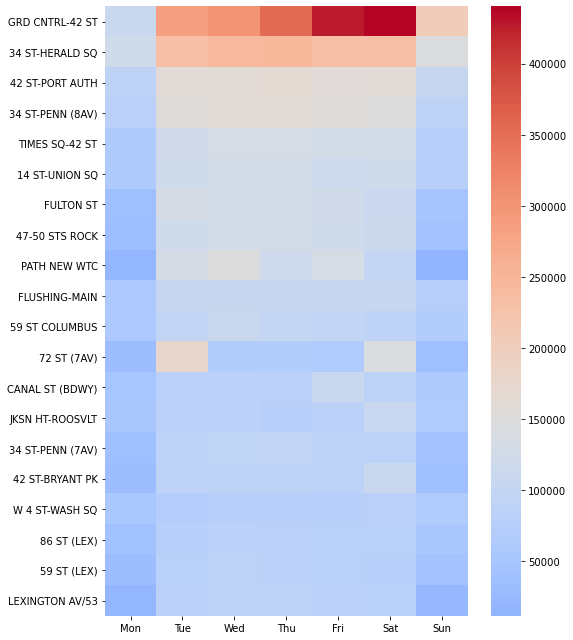

In [34]:
# bring in station labels, and save days of the week to add values to the axes
station_labels = graph_labels
day_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.figure(figsize=(8,9))
hm = sns.heatmap(daily_plot_pivot, cmap="coolwarm",center=150000, xticklabels=day_labels, yticklabels=station_labels)
hm.set(xlabel='',ylabel='');
figure = hm.get_figure()
plt.tight_layout()
figure.savefig('heatmap.jpg')